In [2]:
# ! pip install pandas
# ! pip install numpy
# ! pip install matplotlib
# ! pip install pmdarima
# ! pip install arch

In [26]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import yfinance as yf  # Import yfinance library for fetching historical stock data
import math
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model
from arch.univariate import HARX
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore')


# Task 1

### Task 1.1

In [4]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('content/IBM_202001.csv.gz', compression='gzip')

original_length = len(df)
data = df.copy()
original_length


# F1
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)


# F2
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)


# F2
# Remove entries with negative bid-ask spread
df['SPREAD'] = df['NBO'] - df['NBB']
df = df[~(df['SPREAD'] <= 0)].reset_index(drop=True)

f2 = f1_cleaned_length - len(df)
f2_cleaned_length = len(df)


# F3
df['Stamp'] = pd.to_datetime(df['DATE'], format='%d%b%Y') + df['TIME_M'].apply(lambda x: pd.Timedelta(x,unit='sec'))
# Group by 'DATE', 'TIME', 'EX', and 'BuySell'
df = df.groupby(['Stamp', 'DATE', 'EX', 'BuySell']).agg({
    'PRICE': 'median',
    'NBO': 'median',
    'NBB': 'median',
    'SIZE': 'sum',
    'NBOqty': 'sum',
    'NBBqty': 'sum'
}).reset_index()

f3 = f2_cleaned_length - len(df)
f3_cleaned_length = len(df)


# F4
# Remove entries for which the spread is more that 50 times the median spread on that day
df['SPREAD'] = df['NBO'] - df['NBB']

medspread = df['SPREAD'].median()
df = df[~(df['SPREAD'] > 50*medspread)].reset_index(drop=True)

f4 = f3_cleaned_length - len(df)
f4_cleaned_length = len(df)


# F5
## Delete entries with prices that are above the `ask' plus the bid–ask spread. 
## Similar for entries with prices below the `bid' minus the bid–ask spread
df_out = (df['PRICE'] > df['NBO'] + df['SPREAD']) | (df['PRICE'] < df['NBB'] - df['SPREAD'])
df = df[~df_out]

f5 = f4_cleaned_length - len(df)
f5_cleaned_length = len(df)


# Summary
summary = pd.DataFrame({
    'F1': [f1, f1/original_length*100],
    'F2': [f2, f2/original_length*100],
    'F3': [f3, f3/original_length*100],
    'F4': [f4, f4/original_length*100],
    'F5': [f5, f5/original_length*100],
}, index=['Number', 'Proportion'])
summary.round(2)

,F1,F2,F3,F4,F5
Number,0.0,14375.00,222406.00,0.0,7063.00
Proportion,0.0,1.46,22.58,0.0,0.72


### Task 1.2

In [5]:
df

,Stamp,DATE,EX,BuySell,PRICE,NBO,NBB,SIZE,NBOqty,NBBqty,SPREAD
0,2020-01-02 09:30:00.226,02JAN2020,P,1.0,135.100,135.10,134.88,2.0,1000.0,200.0,0.22
1,2020-01-02 09:30:00.381,02JAN2020,K,1.0,135.090,135.10,134.62,1.0,500.0,600.0,0.48
2,2020-01-02 09:30:00.600,02JAN2020,N,1.0,135.000,135.10,134.62,148164.0,1000.0,1200.0,0.48
3,2020-01-02 09:30:00.609,02JAN2020,N,1.0,134.990,135.10,134.62,11.0,500.0,600.0,0.48
4,2020-01-02 09:30:00.642,02JAN2020,D,1.0,134.995,135.00,134.91,40.0,500.0,100.0,0.09
...,...,...,...,...,...,...,...,...,...,...,...
748390,2020-01-31 15:59:59.987,31JAN2020,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04
748391,2020-01-31 15:59:59.989,31JAN2020,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04
748392,2020-01-31 15:59:59.994,31JAN2020,N,-1.0,143.700,143.71,143.70,10600.0,20800.0,300.0,0.01
748393,2020-01-31 15:59:59.994,31JAN2020,T,-1.0,143.700,143.71,143.70,176.0,20800.0,100.0,0.01


In [6]:
df.set_index('Stamp', drop=True, inplace = True)

In [8]:

# Define all the sampling frequencies
frequencies = ['1S', '2S', '3S', '4S', '5S', '10S', '15S', '20S', '30S',
               '40S', '50S', '1T', '2T', '3T', '4T', '5T', '6T', '7T', '8T',
               '9T', '10T', '15T', '20T', '30T']

# Create empty DataFrames to store the volatility measures
RVdf = pd.DataFrame(index=pd.unique(df['DATE']))
BVdf = pd.DataFrame(index=pd.unique(df['DATE']))
TRVdf = pd.DataFrame(index=pd.unique(df['DATE']))

for freq in frequencies:
    # Resample the data
    df_resampled = df['PRICE'].resample(freq).ohlc()['close']

    # Calculate log returns
    log_returns = np.log(df_resampled).diff().dropna()

    # Calculate Realized Volatility (RV)
    RV = (log_returns**2).resample('D').sum()

    # Calculate Bipower Variation (BV)
    BV = (log_returns.abs().iloc[:-1] * log_returns.abs().shift(-1).iloc[:-1]).resample('D').sum() * (np.pi / 2)

    # Calculate Truncated Realized Volatility (TRV)
    threshold = log_returns.quantile(0.975)  # Using the 97.5th percentile as the threshold
    TRV = (log_returns**2).where(log_returns.abs() <= threshold).resample('D').sum()

    # Assign the measures to respective DataFrames
    RVdf[freq] = RV
    BVdf[freq] = BV
    TRVdf[freq] = TRV

# Display the Realized Volatility DataFrame
print('Realized Volatility (RV):')
print(RVdf.head())

# Display the Bipower Variation DataFrame
print('Bipower Variation (BV):')
print(BVdf.head())

# Display the Truncated Realized Volatility DataFrame
print('Truncated Realized Volatility (TRV):')
print(TRVdf.head())


Realized Volatility (RV):
                 1S        2S        3S        4S        5S       10S  \
02JAN2020  0.000062  0.000072  0.000075  0.000079  0.000070  0.000069   
03JAN2020  0.000102  0.000135  0.000135  0.000137  0.000128  0.000107   
06JAN2020  0.000067  0.000085  0.000081  0.000082  0.000079  0.000064   
07JAN2020  0.000094  0.000121  0.000086  0.000094  0.000096  0.000079   
08JAN2020  0.000064  0.000086  0.000097  0.000103  0.000105  0.000089   

                15S       20S       30S       40S  ...        4T        5T  \
02JAN2020  0.000064  0.000058  0.000055  0.000053  ...  0.000071  0.000053   
03JAN2020  0.000090  0.000087  0.000079  0.000076  ...  0.000076  0.000060   
06JAN2020  0.000049  0.000046  0.000036  0.000036  ...  0.000026  0.000026   
07JAN2020  0.000063  0.000058  0.000056  0.000059  ...  0.000040  0.000033   
08JAN2020  0.000085  0.000075  0.000077  0.000066  ...  0.000050  0.000051   

                 6T        7T        8T        9T       10T       

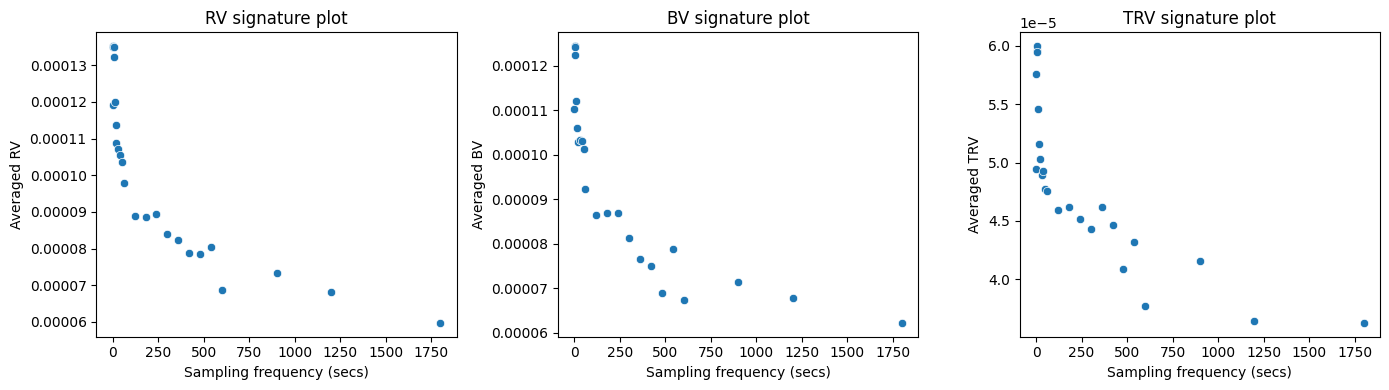

In [12]:
# Compute Average RVs across different days
RVav = RVdf.mean()
# Convert index to integers (sec)
RVav.index
time_RV = [0] + [pd.Timedelta(x).total_seconds() for x in RVav.index[1:]]


# Compute Average RVs across different days
BVav = BVdf.mean()
# Convert index to integers (sec)
BVav.index
time_BV = [0] + [pd.Timedelta(x).total_seconds() for x in BVav.index[1:]]


# Compute Average RVs across different days
TRVav = TRVdf.mean()
# Convert index to integers (sec)
TRVav.index
time_TRV = [0] + [pd.Timedelta(x).total_seconds() for x in TRVav.index[1:]]



fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(14,4))

sns.scatterplot(x=time_RV,y=RVav,ax=axes[0])
axes[0].set_title('RV signature plot')
axes[0].set_xlabel('Sampling frequency (secs)')
axes[0].set_ylabel('Averaged RV')

sns.scatterplot(x=time_BV,y=BVav,ax=axes[1])
axes[1].set_title('BV signature plot')
axes[1].set_xlabel('Sampling frequency (secs)')
axes[1].set_ylabel('Averaged BV')

sns.scatterplot(x=time_TRV,y=TRVav,ax=axes[2])
axes[2].set_title('TRV signature plot')
axes[2].set_xlabel('Sampling frequency (secs)')
axes[2].set_ylabel('Averaged TRV')

plt.tight_layout()

# Task 2

### Task 2.1

In [40]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import random
import pandas as pd
import numpy as np

# Replace 'your_student_id' with your actual student ID number
student_id = 36629202  # Use your actual student ID here
random.seed(student_id)

# Assuming you have DowJones-Feb2022.csv available
djia_stocks = pd.read_csv('DowJones-Feb2022.csv')

# Exclude stock 'DOW' from the list and select two random stocks
djia_stocks = djia_stocks[djia_stocks['Ticker'] != 'DOW']
my_sample = random.sample(djia_stocks['Ticker'].tolist(), 2)

# Fetch the Adjusted Close prices for the selected stocks
stock_prices = {}
for stock in my_sample:
    stock_data = yf.download(stock, start='2010-01-01', end='2023-12-31')
    stock_prices[stock] = stock_data['Adj Close']

# Compute log daily returns for the selected stocks
log_returns = {stock: np.log(prices).diff().dropna() for stock, prices in stock_prices.items()}

# Fit ARMA models and find the best one based on AIC
best_models = {}
for stock, returns in log_returns.items():
    best_aic = float('inf')
    best_order = None
    best_model = None
    # Grid search for p,q values between 0 and 3
    for p in range(4):
        for q in range(4):
            try:
                model = ARIMA(returns, order=(p,0,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,q)
                    best_model = model
            except Exception as e:
                continue
    best_models[stock] = (best_model, best_order, best_aic)

# Print out the best-fitting models and their AIC
for stock, (model, order, aic) in best_models.items():
    if model is not None:
        print(f"Best-fitted ARMA model for {stock}: ARMA{order} - AIC = {aic:.4f}")
    else:
        print(f"No suitable ARMA model found for {stock}.")


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


Best-fitted ARMA model for CSCO: ARMA(1, 0) - AIC = -18842.5869
Best-fitted ARMA model for HD: ARMA(2, 0) - AIC = -19673.2550


### Task 2.2

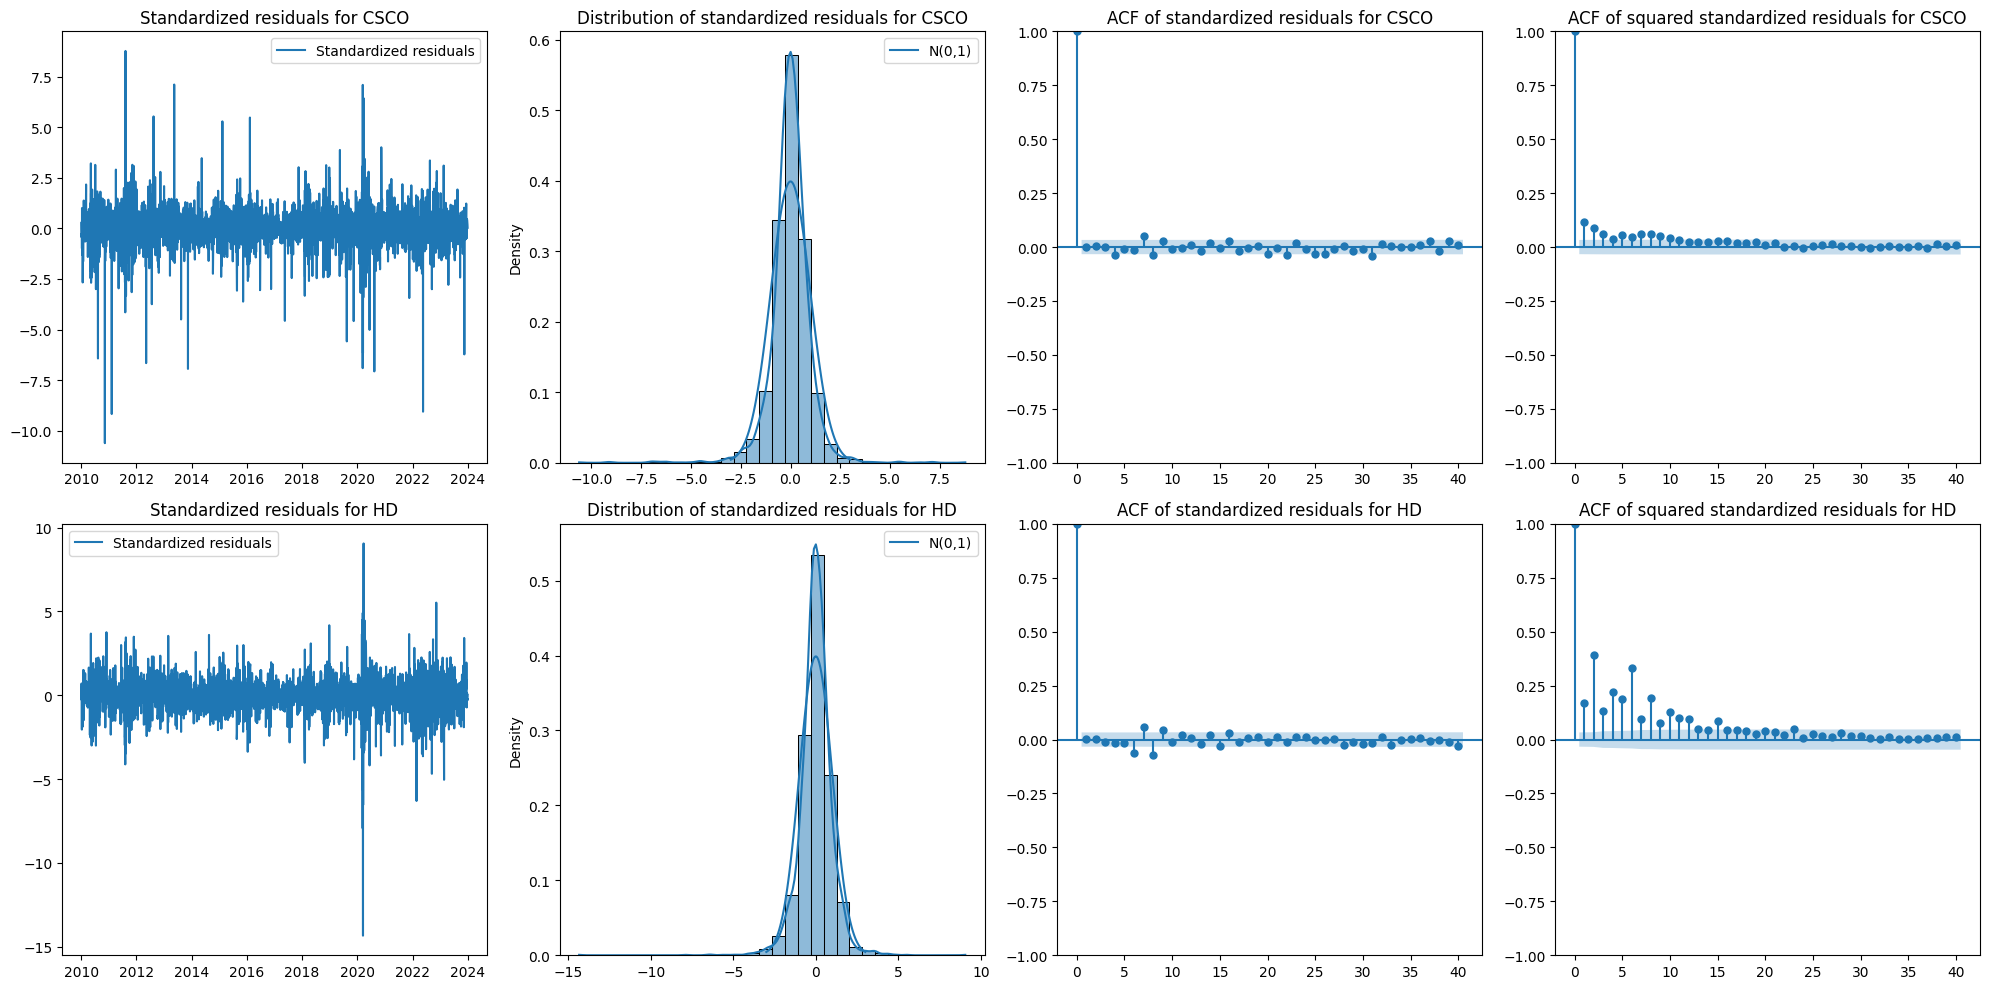

In [42]:
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as scs
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(16,10))
for i, (stock, (model, order, aic)) in enumerate(best_models.items()):
    std_resid = model.resid / model.resid.std()

    # Time series plot of Standardized residuals
    sns.lineplot(x=r.index, y=r, ax=axes[i,0])
    axes[i,0].set_title(f'ARMA({p}, {q}) Standardized residuals-{stock}')
    # distribution of residuals
    sns.histplot(std_resid, kde=True, ax=axes[i, 1], stat='density', bins=30)
    x = np.linspace(-3, 3, 100)
    axes[i, 1].plot(x, stats.norm.pdf(x), label='N(0,1)')
    axes[i, 1].set_title(f'Distribution of standardized residuals for {stock}')
    axes[i, 1].legend()

    # ACF plot of standardized residual
    plot_acf(r, ax=axes[i,2], alpha=0.05)
    axes[i,2].set_title('ACF of standardized residuals')
    # ACF plot of squared standardized residual
    plot_acf(r**2, ax=axes[i,3], alpha=0.05)
    axes[i,3].set_title('ACF of standardized residuals squared')

plt.tight_layout()

### Task 2.3

In [21]:
# Choose ARMA parameters to minimize AIC

def ARMA_parameter(returns):
    aicVal=[]
    for p in range(0,4):
        for q in range(0,4):
            try:
                gm = arch_model(returns,mean='AR',lags=1,vol='GARCH',p=p,q=q,dist='t')
                gm_fit = gm.fit()
                r = gm_fit.std_resid.dropna()
                aicVal.append([p, q, r, gm_fit.aic, gm_fit])
            except:
                continue
    aicVal = pd.DataFrame(aicVal, columns = ['p', 'q', 'r', 'AIC', 'fit'])
    # print(aicVal)
    p,q,r,AIC,fit = aicVal.iloc[aicVal['AIC'].argmin(),]
    gaicdf.loc[returns.name] = {'p': p, 'q': q, 'r': r, 'AIC': AIC, 'fit':fit}

In [22]:
gaicdf = pd.DataFrame(columns = ['p', 'q', 'r', 'AIC', 'fit'])
for stock in my_sample:
    ARMA_parameter(daily_returns[stock])

Iteration:      1,   Func. Count:      7,   Neg. LLF: 126639.73929870306
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1140604.8434521793
Iteration:      3,   Func. Count:     34,   Neg. LLF: 11219.759028759836
Iteration:      4,   Func. Count:     44,   Neg. LLF: 1596709.4060459402
Iteration:      5,   Func. Count:     60,   Neg. LLF: 63627.39841668798
Iteration:      6,   Func. Count:     69,   Neg. LLF: 28572.085481070568
Iteration:      7,   Func. Count:     77,   Neg. LLF: 10079.284583992288
Iteration:      8,   Func. Count:     85,   Neg. LLF: 3239.5330996382463
Iteration:      9,   Func. Count:     92,   Neg. LLF: 12819.94949450723
Iteration:     10,   Func. Count:    101,   Neg. LLF: 8450.768417752635
Iteration:     11,   Func. Count:    110,   Neg. LLF: 266.8247643141019
Iteration:     12,   Func. Count:    117,   Neg. LLF: 193047.23147640887
Iteration:     13,   Func. Count:    132,   Neg. LLF: 766410.6001412326
Inequality constraints incompatible    (Exit mode 4)
   

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:     81,   Neg. LLF: 13082.551459591736
Iteration:      8,   Func. Count:     88,   Neg. LLF: 8550.758007013625
Iteration:      9,   Func. Count:     95,   Neg. LLF: 11748.619424336019
Iteration:     10,   Func. Count:    103,   Neg. LLF: 6885.985143036555
Iteration:     11,   Func. Count:    111,   Neg. LLF: 4580.385918911984
Iteration:     12,   Func. Count:    120,   Neg. LLF: 776418.6600214094
Iteration:     13,   Func. Count:    137,   Neg. LLF: 35998.517388531815
Iteration:     14,   Func. Count:    144,   Neg. LLF: 35604.56912614312
Iteration:     15,   Func. Count:    156,   Neg. LLF: 29140.249325194836
Iteration:     16,   Func. Count:    163,   Neg. LLF: 22363.814068989777
Iteration:     17,   Func. Count:    170,   Neg. LLF: 127534.73261180968
Iteration:     18,   Func. Count:    180,   Neg. LLF: 26396.79250909947
Iteration:     19,   Func. Count:    189,   Neg. LLF: 14968.456172912147
Iteration:     20,   Func. Count:    197,   Neg. LLF: 874

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 89960.81659789893
Iteration:      2,   Func. Count:     27,   Neg. LLF: 33368.60851400897
Iteration:      3,   Func. Count:     38,   Neg. LLF: 10055.133331658575
Iteration:      4,   Func. Count:     49,   Neg. LLF: 7163.0327019900515
Iteration:      5,   Func. Count:     60,   Neg. LLF: 9854.302847923376
Iteration:      6,   Func. Count:     72,   Neg. LLF: 1469466.5046359682
Iteration:      7,   Func. Count:     90,   Neg. LLF: 35647.77840339742
Iteration:      8,   Func. Count:     99,   Neg. LLF: 62902.159937335484
Iteration:      9,   Func. Count:    110,   Neg. LLF: 30637.978881741452
Iteration:     10,   Func. Count:    120,   Neg. LLF: 15156.21160338378
Iteration:     11,   Func. Count:    130,   Neg. LLF: 5289.418776009839
Iteration:     12,   Func. Count:    139,   Neg. LLF: 23417.52497008189
Iteration:     13,   Func. Count:    153,   Neg. LLF: -2487.909391702994
Iteration:     14,   Func. Count:    162,   Neg. LLF: 1041

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      8,   Func. Count:     93,   Neg. LLF: 1897477.2199839074
Iteration:      9,   Func. Count:    110,   Neg. LLF: 534606.910148971
Iteration:     10,   Func. Count:    126,   Neg. LLF: 300014.49579987745
Iteration:     11,   Func. Count:    143,   Neg. LLF: 412772.6530824979
Iteration:     12,   Func. Count:    160,   Neg. LLF: 375009.9599690279
Iteration:     13,   Func. Count:    172,   Neg. LLF: 8184.2230253484995
Iteration:     14,   Func. Count:    180,   Neg. LLF: 16514.08263820389
Iteration:     15,   Func. Count:    190,   Neg. LLF: 6791.888030388065
Iteration:     16,   Func. Count:    198,   Neg. LLF: 13182023.967293262
Iteration:     17,   Func. Count:    214,   Neg. LLF: 280943.43036836566
Optimization terminated successfully    (Exit mode 0)
            Current function value: 280943.430300273
            Iterations: 21
            Function evaluations: 214
            Gradient evaluations: 17
Iteration:      1,   Func. Count:      9,   Neg. LLF: 90156.9135200

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:     82,   Neg. LLF: 55888.29305122036
Iteration:      7,   Func. Count:     99,   Neg. LLF: 342091.8897203279
Iteration:      8,   Func. Count:    115,   Neg. LLF: 52044.3894266047
Iteration:      9,   Func. Count:    132,   Neg. LLF: 30208.506835791104
Iteration:     10,   Func. Count:    147,   Neg. LLF: 13581.69449784794
Iteration:     11,   Func. Count:    162,   Neg. LLF: 1579265.6206963486
Iteration:     12,   Func. Count:    181,   Neg. LLF: 16676.248019532555
Iteration:     13,   Func. Count:    190,   Neg. LLF: 47652.045219285996
Iteration:     14,   Func. Count:    202,   Neg. LLF: 13276.468482288607
Iteration:     15,   Func. Count:    211,   Neg. LLF: 3070678.8210226786
Iteration:     16,   Func. Count:    221,   Neg. LLF: 12802606.592213042
Iteration:     17,   Func. Count:    239,   Neg. LLF: 9439.384105709261
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9439.384105650312
            Iterations

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:     59,   Neg. LLF: 14496.578202050776
Iteration:      6,   Func. Count:     70,   Neg. LLF: 11631400.401748952
Iteration:      7,   Func. Count:     88,   Neg. LLF: 143878.20294416219
Iteration:      8,   Func. Count:    106,   Neg. LLF: 17641963.295271143
Iteration:      9,   Func. Count:    124,   Neg. LLF: 83819.2151600776
Iteration:     10,   Func. Count:    132,   Neg. LLF: 85163.36222159551
Iteration:     11,   Func. Count:    141,   Neg. LLF: 82621.92542472116
Iteration:     12,   Func. Count:    149,   Neg. LLF: 67331.7282251335
Iteration:     13,   Func. Count:    157,   Neg. LLF: 149070.47821367072
Iteration:     14,   Func. Count:    175,   Neg. LLF: 46998069.710627034
Iteration:     15,   Func. Count:    193,   Neg. LLF: 280433.04234038806
Iteration:     16,   Func. Count:    201,   Neg. LLF: 267933.9572701797
Iteration:     17,   Func. Count:    208,   Neg. LLF: 267933.9574564862
Optimization terminated successfully    (Exit mode 0)
     

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    153,   Neg. LLF: 9640.781766919223
Iteration:     11,   Func. Count:    163,   Neg. LLF: 14815.401942860177
Iteration:     12,   Func. Count:    177,   Neg. LLF: 27714.674330939673
Iteration:     13,   Func. Count:    190,   Neg. LLF: 8733.704830629285
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1495.1285689281763
Iteration:     15,   Func. Count:    210,   Neg. LLF: 16396.31791692465
Iteration:     16,   Func. Count:    225,   Neg. LLF: 8134.150028381399
Iteration:     17,   Func. Count:    237,   Neg. LLF: 18912.99035101965
Iteration:     18,   Func. Count:    252,   Neg. LLF: 10752.108285898143
Iteration:     19,   Func. Count:    264,   Neg. LLF: 735483.2331135941
Iteration:     20,   Func. Count:    284,   Neg. LLF: 11189.491017508124
Iteration:     21,   Func. Count:    294,   Neg. LLF: 17991.11272043507
Iteration:     22,   Func. Count:    306,   Neg. LLF: 94704.62713933515
Iteration:     23,   Func. Count:    325,   Neg. LLF: 11445

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 89108.08876155344
Iteration:      2,   Func. Count:     33,   Neg. LLF: 1190119.653500162
Iteration:      3,   Func. Count:     50,   Neg. LLF: 8566.569560494183
Iteration:      4,   Func. Count:     63,   Neg. LLF: 3297.4411392403977
Iteration:      5,   Func. Count:     75,   Neg. LLF: 17101.375632895702
Iteration:      6,   Func. Count:     88,   Neg. LLF: 995.4644377974573
Iteration:      7,   Func. Count:    100,   Neg. LLF: 92138.90597338021
Iteration:      8,   Func. Count:    121,   Neg. LLF: 18359.598715232187
Iteration:      9,   Func. Count:    142,   Neg. LLF: 13325.04094405023
Iteration:     10,   Func. Count:    156,   Neg. LLF: 14766.95361430779
Iteration:     11,   Func. Count:    168,   Neg. LLF: 13122.05061214507
Iteration:     12,   Func. Count:    181,   Neg. LLF: 1140456.4386947074
Iteration:     13,   Func. Count:    195,   Neg. LLF: 420806.56305426534
Iteration:     14,   Func. Count:    207,   Neg. LLF: 47966

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     10,   Func. Count:    117,   Neg. LLF: 178335.8696137977
Iteration:     11,   Func. Count:    123,   Neg. LLF: 178335.87013142928
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178335.8696137977
            Iterations: 15
            Function evaluations: 123
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      9,   Neg. LLF: 89504.48967113344
Iteration:      2,   Func. Count:     27,   Neg. LLF: 26919248.908633832
Iteration:      3,   Func. Count:     45,   Neg. LLF: 3144613.4859581604
Iteration:      4,   Func. Count:     56,   Neg. LLF: 69732.13183555196
Iteration:      5,   Func. Count:     67,   Neg. LLF: 6613.139721589378
Iteration:      6,   Func. Count:     76,   Neg. LLF: 7176.756153657065
Iteration:      7,   Func. Count:     88,   Neg. LLF: 1559866.096898248
Iteration:      8,   Func. Count:    106,   Neg. LLF: 36732.64164889289
Iteration:      9,   Func. Count:    114,   Neg. LLF: 38037.5090478

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      6,   Func. Count:     69,   Neg. LLF: 186948.71431502976
Iteration:      7,   Func. Count:     86,   Neg. LLF: 37428.13261415725
Iteration:      8,   Func. Count:     95,   Neg. LLF: 7482.212938101458
Iteration:      9,   Func. Count:    103,   Neg. LLF: 14859.149493754838
Iteration:     10,   Func. Count:    111,   Neg. LLF: 29030.420842043815
Iteration:     11,   Func. Count:    122,   Neg. LLF: 386545.3025536622
Iteration:     12,   Func. Count:    135,   Neg. LLF: 1045035.9229338584
Iteration:     13,   Func. Count:    152,   Neg. LLF: 1865140.4283193639
Iteration:     14,   Func. Count:    169,   Neg. LLF: 110913.19229458229
Iteration:     15,   Func. Count:    186,   Neg. LLF: 355917.2941228807
Iteration:     16,   Func. Count:    195,   Neg. LLF: 7593.9675060757345
Iteration:     17,   Func. Count:    202,   Neg. LLF: 11849.11659985326
Iteration:     18,   Func. Count:    216,   Neg. LLF: 94171.88641421054
Iteration:     19,   Func. Count:    227,   Neg. LLF: 139

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      9,   Func. Count:    131,   Neg. LLF: 34221.905823139175
Iteration:     10,   Func. Count:    140,   Neg. LLF: 33515.83417253587
Iteration:     11,   Func. Count:    149,   Neg. LLF: 29549.489088025133
Iteration:     12,   Func. Count:    158,   Neg. LLF: 33743.58683727977
Iteration:     13,   Func. Count:    168,   Neg. LLF: 1500126.4442147324
Iteration:     14,   Func. Count:    183,   Neg. LLF: 28350.482997666008
Iteration:     15,   Func. Count:    197,   Neg. LLF: 31438.06720918937
Iteration:     16,   Func. Count:    209,   Neg. LLF: 5973.1644267473575
Iteration:     17,   Func. Count:    218,   Neg. LLF: 13903.25501934675
Iteration:     18,   Func. Count:    229,   Neg. LLF: 10692.37215543302
Iteration:     19,   Func. Count:    240,   Neg. LLF: 178766.13664385822
Iteration:     20,   Func. Count:    259,   Neg. LLF: 91483.17910231164
Iteration:     21,   Func. Count:    269,   Neg. LLF: 3722.595491004779
Iteration:     22,   Func. Count:    279,   Neg. LLF: 1964

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     11,   Func. Count:    157,   Neg. LLF: 300074.987132061
Iteration:     12,   Func. Count:    177,   Neg. LLF: 49132622.10282945
Iteration:     13,   Func. Count:    197,   Neg. LLF: 280460.4752012029
Iteration:     14,   Func. Count:    207,   Neg. LLF: 278915.54029708303
Iteration:     15,   Func. Count:    217,   Neg. LLF: 278915.50802890706
Iteration:     16,   Func. Count:    226,   Neg. LLF: 278915.50827100547
Optimization terminated successfully    (Exit mode 0)
            Current function value: 278915.50802890706
            Iterations: 20
            Function evaluations: 226
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      9,   Neg. LLF: 359433.77235721087
Iteration:      2,   Func. Count:     27,   Neg. LLF: 1809024.3641722798
Iteration:      3,   Func. Count:     40,   Neg. LLF: 16933.899175729985
Iteration:      4,   Func. Count:     52,   Neg. LLF: 45021.71190686445
Iteration:      5,   Func. Count:     68,   Neg. LLF: 636688.681

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     17,   Func. Count:    207,   Neg. LLF: 11772.579500048878
Iteration:     18,   Func. Count:    216,   Neg. LLF: 11666.419854278047
Iteration:     19,   Func. Count:    225,   Neg. LLF: 27404.508173058355
Iteration:     20,   Func. Count:    237,   Neg. LLF: 35890.586577699534
Iteration:     21,   Func. Count:    248,   Neg. LLF: 11527.565672174707
Iteration:     22,   Func. Count:    257,   Neg. LLF: 13920.475271978812
Iteration:     23,   Func. Count:    267,   Neg. LLF: 16421.218974419175
Iteration:     24,   Func. Count:    277,   Neg. LLF: 29311.93351009295
Iteration:     25,   Func. Count:    289,   Neg. LLF: 30201.822429422384
Iteration:     26,   Func. Count:    301,   Neg. LLF: 14609.303023926794
Iteration:     27,   Func. Count:    311,   Neg. LLF: 14231.192673847885
Iteration:     28,   Func. Count:    322,   Neg. LLF: 5528.826053180446
Iteration:     29,   Func. Count:    332,   Neg. LLF: 4482.716864761516
Iteration:     30,   Func. Count:    342,   Neg. LLF: 

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 88529.05538583316
Iteration:      2,   Func. Count:     33,   Neg. LLF: 3235711.1460416187
Iteration:      3,   Func. Count:     51,   Neg. LLF: 13913.769072687453
Iteration:      4,   Func. Count:     65,   Neg. LLF: 1483004.3355985912
Iteration:      5,   Func. Count:     86,   Neg. LLF: 41879.42069620914
Iteration:      6,   Func. Count:     97,   Neg. LLF: 78262.23146172051
Iteration:      7,   Func. Count:    115,   Neg. LLF: 36651.44865996353
Iteration:      8,   Func. Count:    126,   Neg. LLF: 36219.38092530906
Iteration:      9,   Func. Count:    137,   Neg. LLF: 2589192.4821634283
Iteration:     10,   Func. Count:    152,   Neg. LLF: 8157590.170034037
Iteration:     11,   Func. Count:    173,   Neg. LLF: 7175.899595033507
Iteration:     12,   Func. Count:    187,   Neg. LLF: 52987.92297274461
Iteration:     13,   Func. Count:    205,   Neg. LLF: 5514.534008031142
Iteration:     14,   Func. Count:    217,   Neg. LLF: 24187.

In [23]:
for stock in my_sample:
    print(f'Best-fitted AR(p)-GARCH(p*,q*) model for {stock}: AR({aicdf['p'][stock]})-GARCH({gaicdf['p'][stock]},{gaicdf['q'][stock]}) - AIC = {gaicdf['AIC'][stock]}')

Best-fitted AR(p)-GARCH(p*,q*) model for HD: AR(1)-GARCH(3,3) - AIC = -746.5871651813184
Best-fitted AR(p)-GARCH(p*,q*) model for WMT: AR(1)-GARCH(3,0) - AIC = -16520.649089642124


### Task 2.4

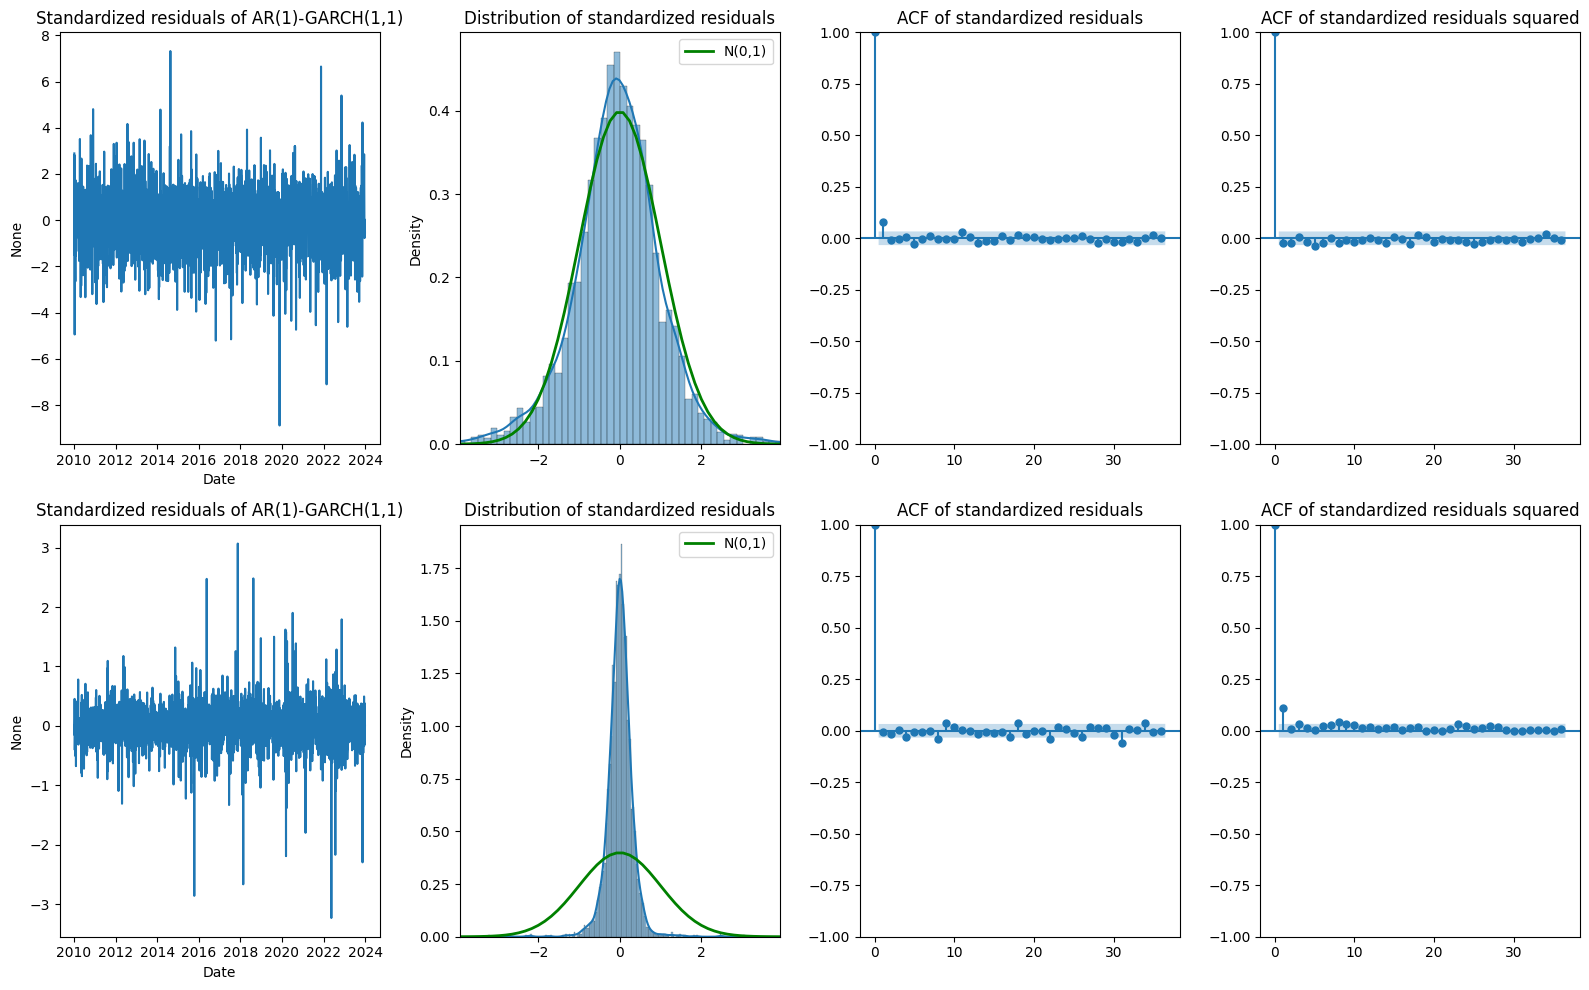

In [36]:
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as scs
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(16,10))
for i,stock in enumerate(my_sample):
    p = gaicdf.loc[stock]['p']
    q = gaicdf.loc[stock]['q']
    r = gaicdf.loc[stock]['r'] # Extract standardized residuals
    r.name = None

    # Time series plot of Standardized residuals
    sns.lineplot(x=r.index, y=r, ax=axes[i,0])
    axes[i,0].set_title('Standardized residuals of AR(1)-GARCH(1,1)')
    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.histplot(r,kde=True,stat='density',ax=axes[i,1])
    axes[i,1].plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    axes[i,1].set_title('Distribution of standardized residuals')
    axes[i,1].set_xlim(x_lim)
    axes[i,1].legend()
    # ACF plot of standardized residual
    plot_acf(r, ax=axes[i,2], alpha=0.05)
    axes[i,2].set_title('ACF of standardized residuals')
    # ACF plot of squared standardized residual
    plot_acf(r**2, ax=axes[i,3], alpha=0.05)
    axes[i,3].set_title('ACF of standardized residuals squared')

plt.tight_layout()

### Task 2.5

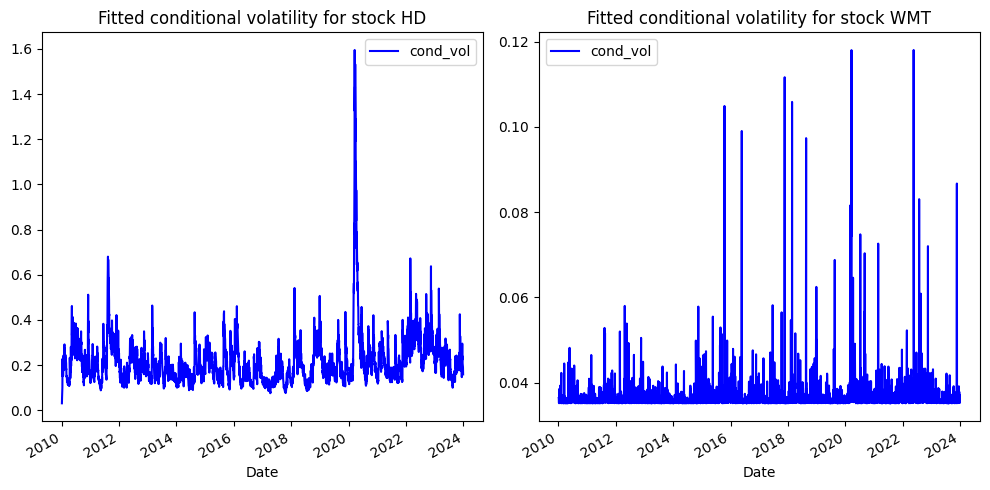

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
for i,stock in enumerate(my_sample):
    gaicdf['fit'][stock].conditional_volatility.plot(ax = axes[i], c = 'b')
    axes[i].set_title(f'Fitted conditional volatility for stock {stock}')
    axes[i].legend()
plt.tight_layout()
plt.show()

# Task 3

### Task 3.1